# This notebook is for plotting the full distributions of $\langle \cos^2{\theta}\rangle_T$ as a function of $T$. It takes a while to run if you want the distributions to look smooth, but a low res. version is fast

In [4]:
from numpy import *
from PlotFuncs import *
from LabFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
from numpy import random
from scipy.integrate import cumtrapz
import cmocean
from tqdm import tqdm

def costh_T_histogram(fcosth2,lat,Tmax,nt=2000,nbins=2000,ngen=100000):
    '''
    This function is for making the histogram of <cos^2(th)>_T for an array of T
    thereby making a series of histograms that can be plotted
    
    INPUT:
    fcosth2 = the function name of the relevant angle, e.g. costh2N, costh2W, costh2Z
    lat = latitude in degrees
    Tmax = largest value of T to plot
    nt = number of values of T to plot
    nbins = number of bins in <cos^2(th)>_T
    ngen = number of DP polarisations to sample over
    
    OUTPUT:
    T = array of T (size=nt)
    ce = bin edges of <cos^2(th)>_T histogram (size=nbins+1)
    H = array of histograms (size=(nbins,nt))
    C_05 = 5th percentile of distribution at each T (size=nt)
    C_50 = 50th percentile of distribution at each T (size=nt)
    C_95 = 95th percentile of distribution at each T (size=nt)
    '''
    costh_X = 2*random.uniform(size=ngen)-1
    phi_X = 2*pi*random.uniform(size=ngen)
    
    T = linspace(0,Tmax,nt+1)

    c1t = zeros(shape=(ngen,nt+1))

    for i in range(0,nt+1):
        c1t[:,i] = fcosth2(T[i],costh_X,phi_X,lat)

    # Calculate the time average at each T by doing a cumulative average
    c_av = cumtrapz(c1t,T)/T[1:]
    
    # Now calculate various statistics and bin up the results into a histogram
    C_05 = zeros(shape=nt)
    C_50 = zeros(shape=nt)
    C_95 = zeros(shape=nt)
    H = zeros(shape=(nbins,nt))
    for i in tqdm(range(0,nt)):
        H[:,i],ce = histogram(c_av[:,i],nbins,range=[0,1])
        
        sort_c = sort(c_av[:,i])
        C_05[i] = sort_c[int(0.05*ngen)] # 5th percentile
        C_50[i] = sort_c[int(0.5*ngen)] # Median
        C_95[i] = sort_c[int(0.95*ngen)] # 95th percentile
    
    return T[1:],ce,H,C_05,C_50,C_95


# Make three histograms for three latitudes
lat1 = 35
lat2 = 45
lat3 = 55

# North-pointing experiments first
direction_label = r'{\bf North-pointing}'
figname = 'North_costh_dist'
cmap = cmocean.cm.algae
T,ce,H1,C1_05,C1_50,C1_95 = costh_T_histogram(costh2N,lat1,4)
T,ce,H2,C2_05,C2_50,C2_95 = costh_T_histogram(costh2N,lat2,4)
T,ce,H3,C3_05,C3_50,C3_95 = costh_T_histogram(costh2N,lat3,4)

# Now we just plot the results using pcolormesh

In [2]:
import matplotlib.colors as colors
import matplotlib.patheffects as pe
pek=[pe.Stroke(linewidth=3, foreground='k',alpha=1), pe.Normal()]

def Plot_costh_T_histogram(ax,T,ce,H,C_05,C_95,cmap,lat,direction_label,cbar_lab='',vmin=1e-3,cbar_on=False,mean_val=1/3):
    plt.sca(ax)
    norm = colors.LogNorm(vmin=vmin, vmax=1)
    cc = (ce[1:]+ce[0:-1])/2
    im = ax.pcolormesh(T,ce,(H/amax(H)),cmap=cmap,norm=norm,rasterized=True)
    ax.plot(T,C_05,'w--',path_effects=pek,lw=2)
    ax.plot(T,C_95,'w--',path_effects=pek,lw=2)
    ax.axhline(mean_val,color='k',lw=2.5,linestyle='--')
    if cbar_on:
        cbar(im,extend='min')
        plt.gcf().text(0.95,0.50,cbar_lab,ha='center',rotation_mode='anchor',rotation=-90,fontsize=33)
    return

xlab = ''
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'
fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_05,C1_95,cmap,lat1,direction_label)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_05,C2_95,cmap,lat2,direction_label)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_05,C3_95,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True)

ax1.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat1))+r'$^\circ$',fontsize=33)
ax2.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat2))+r'$^\circ$',fontsize=33)
ax3.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat3))+r'$^\circ$',fontsize=33)

plt.gcf().text(0.865,0.78,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])

MySaveFig(fig,figname)

In [10]:
# Exactly the same but for zenith-pointing experiments
direction_label = r'{\bf Zenith-pointing}'
figname = 'Zenith_costh_dist'
cmap = cm.Reds
T,ce,H1,C1_05,C1_50,C1_95 = costh_T_histogram(costh2Z,lat1,4)
T,ce,H2,C2_05,C2_50,C2_95 = costh_T_histogram(costh2Z,lat2,4)
T,ce,H3,C3_05,C3_50,C3_95 = costh_T_histogram(costh2Z,lat3,4)

100%|██████████| 2000/2000 [00:20<00:00, 96.26it/s] 


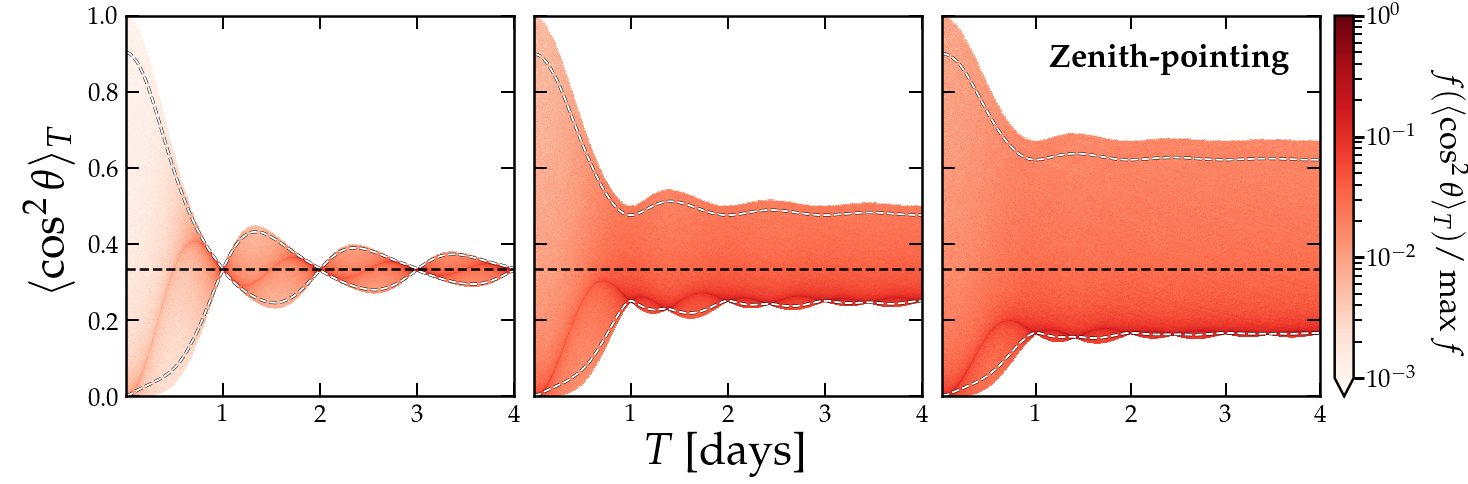

In [11]:
xlab = r'$T$ [days]'
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'
fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_05,C1_95,cmap,lat1,direction_label)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_05,C2_95,cmap,lat2,direction_label)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_05,C3_95,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True)

plt.gcf().text(0.86,0.78,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])

MySaveFig(fig,figname)

In [5]:
direction_label = r'{\bf North-facing}'
figname = 'NorthFacing_costh_dist'
cmap = cmocean.cm.algae
T,ce,H1,C1_05,C1_50,C1_95 = costh_T_histogram(costh2ZW,lat1,4)
T,ce,H2,C2_05,C2_50,C2_95 = costh_T_histogram(costh2ZW,lat2,4)
T,ce,H3,C3_05,C3_50,C3_95 = costh_T_histogram(costh2ZW,lat3,4)

100%|██████████| 2000/2000 [00:20<00:00, 95.86it/s]


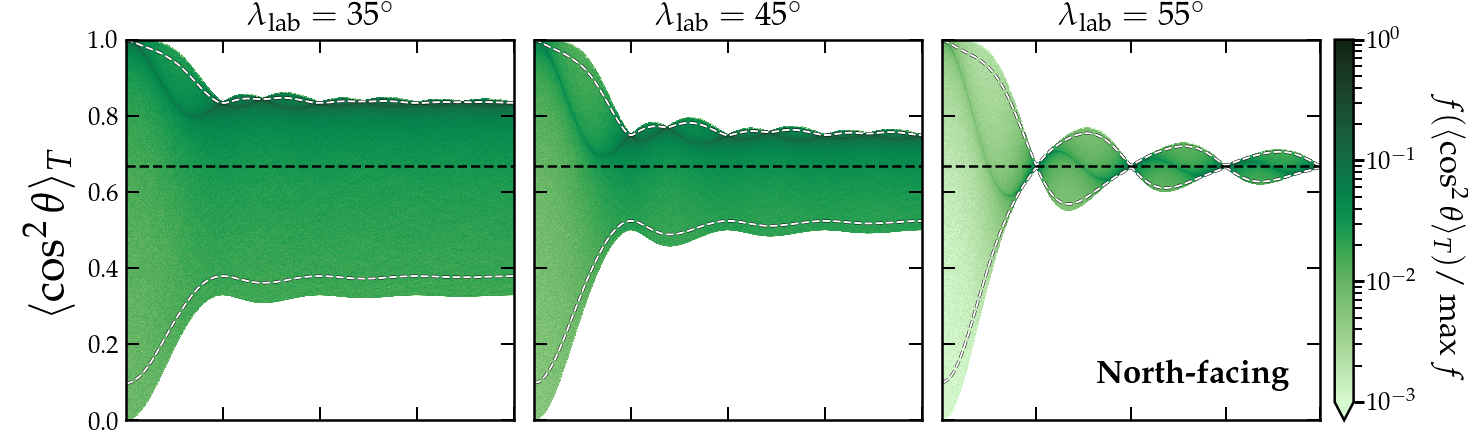

In [6]:
#xlab = r'$T$ [days]'
xlab = ''
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'

fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_05,C1_95,cmap,lat1,direction_label,mean_val=2/3)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_05,C2_95,cmap,lat2,direction_label,mean_val=2/3)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_05,C3_95,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True,mean_val=2/3)

ax1.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat1))+r'$^\circ$',fontsize=33)
ax2.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat2))+r'$^\circ$',fontsize=33)
ax3.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat3))+r'$^\circ$',fontsize=33)

plt.gcf().text(0.86,0.2,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])

MySaveFig(fig,figname)

In [7]:
direction_label = r'{\bf Zenith-facing}'
figname = 'ZenithFacing_costh_dist'
cmap = cm.Reds
T,ce,H1,C1_05,C1_50,C1_95 = costh_T_histogram(costh2NW,lat1,4)
T,ce,H2,C2_05,C2_50,C2_95 = costh_T_histogram(costh2NW,lat2,4)
T,ce,H3,C3_05,C3_50,C3_95 = costh_T_histogram(costh2NW,lat3,4)

100%|██████████| 2000/2000 [00:23<00:00, 86.70it/s]


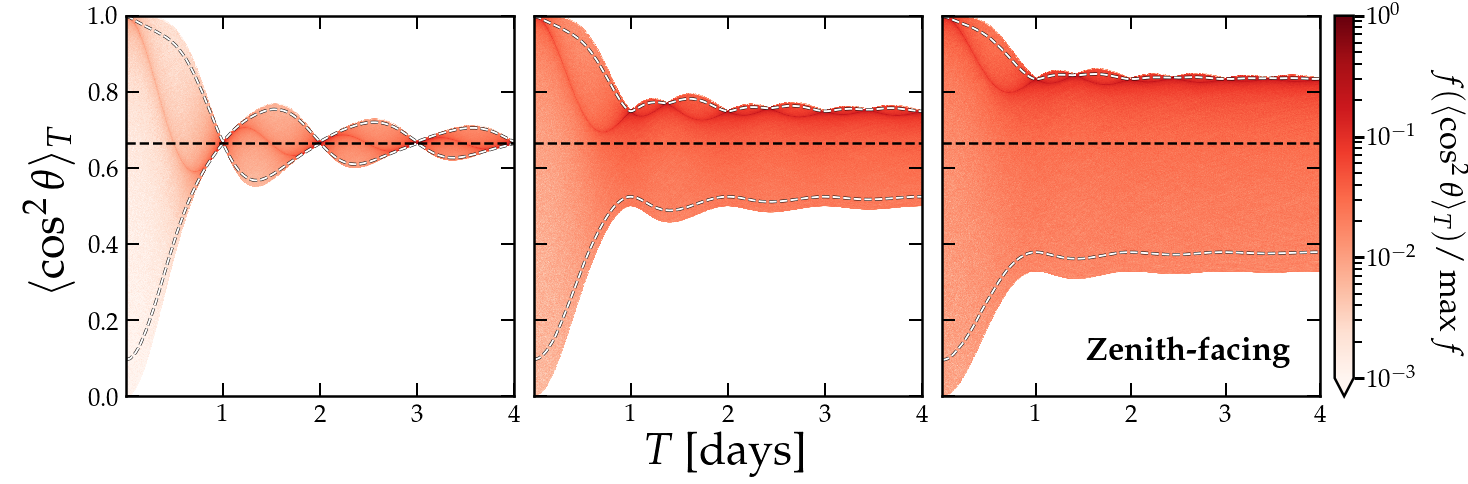

In [9]:
xlab = r'$T$ [days]'
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'

fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_05,C1_95,cmap,lat1,direction_label,mean_val=2/3)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_05,C2_95,cmap,lat2,direction_label,mean_val=2/3)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_05,C3_95,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True,mean_val=2/3)

plt.gcf().text(0.86,0.2,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])

MySaveFig(fig,figname)